# Facial Landmark Detection 

The web-caricature dataset contains images that give us the ability to train and test our network. But what if we want to generate new caricatures new faces? We will need to generate the same set of facial landmarks for these new examples.

We will use dlib popular face detection / landmark detection model to do. 

http://dlib.net/face_detector.py.html
https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/


There is only one landmark missing from the 68 landmark detection model, which is contained within the web Caricature dataset. That is the one point on the forehead. We could either exclude the forehead point whilst training, or find another model which captures this landmark. After hunting around I found this model:

https://github.com/codeniko/shape_predictor_81_face_landmarks

Let's look at the facial landmarks we are trying to detect, the models we are trying to use to detect them and create a mapping between the two manually.

### WebCaricature

<img src='Landmarks_black.jpg'>

### Dlib Model

<img src='dlib_landmarks.png'>

### EOS Model

<img src='eos_landmarks.png'>


* WebC: 1 - EOS: 71
* WebC: 2 - Dlib: 1
* WebC: 3 - Dlib: 8
* WebC: 4 - Dlib: 15
* WebC: 5 - Dlib: 17
* WebC: 6 - Dlib: 21
* WebC: 7 - Dlib: 22
* WebC: 8 - Dlib: 26
* WebC: 9 - Dlib: 36
* WebC: 10 - Dlib: 39
* WebC: 11 - Dlib: 42
* WebC: 12 - Dlib: 45
* WebC: 13 - Dlib: 30
* WebC: 14 - Dlib: 51
* WebC: 15 - Dlib: 48
* WebC: 16 - Dlib: 57
* WebC: 17 - Dlib: 54

In [1]:
import cv2
import numpy as np
import dlib
import os
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import pandas as pd

In [2]:
def get_landmarks(image):

    # define detector and shape predictors
    detector = dlib.get_frontal_face_detector()
    model_dlib = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    model_eos = dlib.shape_predictor('shape_predictor_81_face_landmarks.dat')

    # grayscale version of image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # detect faces in picture (There may be many faces)
    face = detector(gray)

    # assert there must only be one face in the image
    assert(len(face) == 1)

    face = face[0]

    # detect faical landmarks 
    landmarks_dlib = model_dlib(gray, face)
    landmarks_eos = model_eos(gray, face)

    # map coords to new webcari model
    landmark_map = {0:[landmarks_eos, 71],
                    1:[landmarks_dlib, 1],
                    2:[landmarks_dlib, 8],
                    3:[landmarks_dlib, 15],
                    4:[landmarks_dlib, 17],
                    5:[landmarks_dlib, 21],
                    6:[landmarks_dlib, 22],
                    7:[landmarks_dlib, 26],
                    8:[landmarks_dlib, 36],
                    9:[landmarks_dlib, 39],
                    10:[landmarks_dlib, 42],
                    11:[landmarks_dlib, 45],
                    12:[landmarks_dlib, 30],
                    13:[landmarks_dlib, 51],
                    14:[landmarks_dlib, 48],
                    15:[landmarks_dlib, 57],
                    16:[landmarks_dlib, 54]}

    coords = []
    for ldmk_id in landmark_map.keys():
        model = landmark_map[ldmk_id][0]
        n = landmark_map[ldmk_id][1]
        coord = [model.part(n).x, model.part(n).y]
        coords.append(coord)


    # left eye
    coords.append([((coords[8][0] + coords[9][0])/2.0), ((coords[8][1] + coords[8][1])/2.0)])

    # right eye
    coords.append([((coords[10][0] + coords[11][0])/2.0), ((coords[10][1] + coords[11][1])/2.0)])

    # centre mouth
    coords.append([((coords[13][0] + coords[15][0])/2.0), ((coords[13][1] + coords[15][1])/2.0)])

    coords = np.array(coords)
    coords = coords.reshape(1,40)

    return coords

In [3]:
def affine_transform(image, coords, to_affine_trans_coords):
    
    # extract affine coords to:
    coords = coords.reshape(20,2)
    cle_from = coords[17:18]
    cre_from = coords[18:19]
    cm_from = coords[19:20]
    from_affine_trans_coords = [cle_from, cre_from, cm_from]
    from_affine_trans_coords = np.float32(from_affine_trans_coords)
    
    # affine transform image
    matrix = cv2.getAffineTransform(from_affine_trans_coords, to_affine_trans_coords)
    cols, rows = image.shape[0], image.shape[1]
    result = cv2.warpAffine(image, matrix, (cols, rows))
    
    # affine transform coordinates
    coords = np.float32(coords.reshape(20,2))
    coords_affine = np.matmul(matrix, (np.append(coords, np.ones((20,1)), axis=1)).T).T
    
    return result, coords_affine


def crop_scale(image, coords):
    
    coords = coords.reshape(20,2)
    
    # landmark min/max
    xmin, xmax = int(coords[:,:1].min()), int(coords[:,:1].max())
    ymin, ymax = int(coords[:,1:].min()), int(coords[:,1:].max())
    
    # scaling
    horiz_scale = 0.5
    vert_scale = 0.5
    
    # find origin and width of crop
    crop_width = (xmax - xmin) * (1.0 + horiz_scale)
    crop_height = (ymax - ymin) * (1.0 + vert_scale)
    crop_square = int(max(crop_width, crop_height))

    xmin_new = int(((xmin+xmax)/2.0)) - int(crop_square/2.0)
    xmax_new = int(((xmin+xmax)/2.0)) + int(crop_square/2.0)
    ymin_new = int(((ymin+ymax)/2.0)) - int(crop_square/2.0)
    ymax_new = int(((ymin+ymax)/2.0)) + int(crop_square/2.0)

    # crop image
    image_crop = image[max(ymin_new,0):ymax_new, max(xmin_new,0):xmax_new]

    # add black padding and size to square
    image_square = np.zeros((crop_square,crop_square,3), np.uint8)
    image_square[0:min(image_crop.shape[0],crop_square),0:min(image_crop.shape[1],crop_square)] = image_crop[:,:]
    
    # resize image
    newx, newy = 256, 256
    image_square_resize = cv2.resize(image_square,(newx,newy))
    
    # transformed coordinates
    coords_new = + coords - [max(xmin_new,0), max(ymin_new,0)]
    coords_new[:,1:2] = (newy / image_square.shape[1]) * coords_new[:,1:2]
    coords_new[:,0:1] = (newx / image_square.shape[0]) * coords_new[:,0:1]
    
    return image_square_resize, coords_new


In [4]:
# image and coords
image = cv2.imread('IMG_0042.jpg')
coords = get_landmarks(image)

'''
Affine transform coordinates extracted using preprocessing steps in previous workbook

# get to affine trans coords
coord_df = pd.read_csv('coords_A.csv', index_col=0)

cle_mean_x = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,0:1,0:1].mean()
cle_mean_y = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,0:1,1:2].mean()
cre_mean_x = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,1:2,0:1].mean()
cre_mean_y = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,1:2,1:2].mean()
cm_mean_x = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,2:3,0:1].mean()
cm_mean_y = coord_df.to_numpy().reshape(coord_df.shape[0], 20, 2)[:,17:20,:][:,2:3,1:2].mean()

'''

cle_mean_x = 91.28802490234375
cle_mean_y = 106.10215759277344
cre_mean_x = 140.8697052001953
cre_mean_y = 104.94566345214844
cm_mean_x = 116.88267517089844
cm_mean_y = 168.0266571044922


cle_to = cle_mean_x, cle_mean_y
cre_to = cre_mean_x, cre_mean_y
cm_to = cm_mean_x, cm_mean_y

to_affine_coords = [cle_to, cre_to, cm_to]
to_affine_coords = np.float32(to_affine_coords)

image_cs, coords_cs = crop_scale(image, coords)
image_trans, coords_trans = affine_transform(image_cs, coords_cs, to_affine_coords)

In [5]:
cv2.imwrite('new/new.jpg', image_trans);
coords_trans = coords_trans.reshape(1,40)
coords_df = pd.DataFrame(coords_trans)
coords_df.to_csv('new/new_coords.csv')

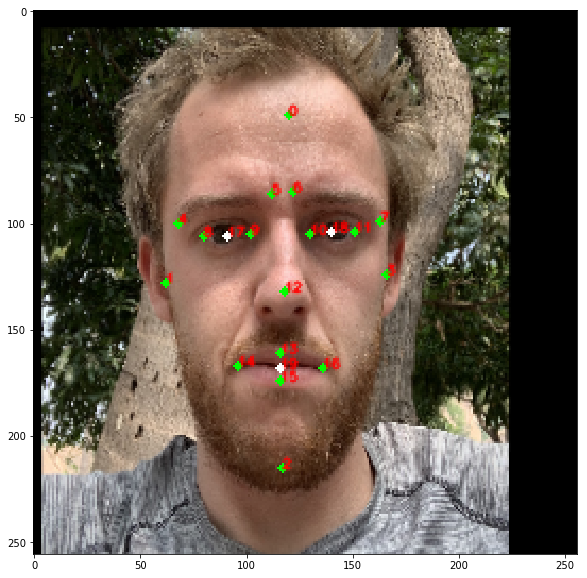

In [6]:
coords_trans = coords_trans.reshape(20,2)

# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (50, 50) 
  
# fontScale 
fontScale = 0.2
   
# Blue color in BGR 
color = (0, 0, 255) 
  
# Line thickness of 2 px 
thickness = 1

for i, coord in enumerate(coords_trans):
    if i in range(17,20):
        x = int(coord[0])
        y = int(coord[1])
        cv2.circle(image_trans, (x, y), 2, (255, 255, 255), -1)
        image_trans = cv2.putText(image_trans, str(i), (x,y), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
        
    else:
        x = int(coord[0])
        y = int(coord[1])
        cv2.circle(image_trans, (x, y), 2, (0, 255, 0), -1)
        image_trans = cv2.putText(image_trans, str(i), (x,y), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 

image_trans = cv2.cvtColor(image_trans, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image_trans);